# Why this data ? 

<ul style="font-size: 1.7rem" >
    <li> Can't remember a familiar song in the club or the restaurant. But the sentimentality of the song really touches your heart. You desperately want to heart it tomorrow. </li>
    <li>You have a phone with music recognition software installed so the software tell you the name of the song, and you know that you can hear it again and again until it becomes a part of you…or you get sick of it.</li>
    <li>Wanted to add something similar to software recognition in our application so we changed data </li>
</ul>    

# Description of Data Set

<p style="font-size: 1.7rem"> Our data set includes

<ul style="font-size: 1.7rem" >
    <li> Song Tittle</li>
    <li> Song Author</li>
    <li> Song Genre </li>
    <li> Song Fingerprints </li>

</ul>    

# Gathering all data set 

<p style="font-size: 1.7rem"> We started our way with datasets, so we put songs in folder and started converting each to byte array </p> 
<p style="font-size: 1.7rem"> From songs name we have author, tittle, genre and fingerprint  </p> 
<p style="font-size: 1.7rem"> Converting each song into bytes array by using code below  </p> 

In [ ]:
fs, data = wavfile.read(filename) # load the data

<p style="font-size: 1.7rem"> Plotting the data of one of out songs </p>

In [ ]:
# this is a two channel soundtrack, I get the first track
a = data.T[0] 
plt.plot(a,'r') 
plt.show()

<p style="font-size: 1.7rem"> representation of one song in byte format  </p>
<img src='Capture2.JPG'>


# The Discrete Fourier Transform
<p style="font-size: 1.7rem">  So we need to find a way to convert our signal from the time domain to the frequency domain. Here we call on the Discrete Fourier Transform (DFT) for help. The DFT is a mathematical methodology for performing Fourier analysis on a discrete (sampled) signal. It converts a finite list of equally spaced samples of a function into the list of coefficients of a finite combination of complex sinusoids, ordered by their frequencies, by considering if those sinusoids had been sampled at the same rate.  </p>

<img src="Fourie_rtransform.jpg">

<p style="font-size: 1.7rem"> One of the most popular numerical algorithms for the calculation of DFT is the Fast Fourier transform (FFT). By far the most commonly used variation of FFT is the Cooley–Tukey algorithm. This is a divide-and-conquer algorithm that recursively divides a DFT into many smaller DFTs. Whereas evaluating a DFT directly requires O(n2) operations, with a Cooley-Tukey FFT the same result is computed in O(n log n) operations. </p>
<p style="font-size: 1.7rem"> So the song after the <b>FFT Analysis</b>  </p>
<img src="FFt_res.jpg">

<p style="font-size: 1.7rem"> It’s not hard to find an appropriate library for FFT. Here are few of them: Python – <b>NumPy</b> </p>
<img src="numpy.jpg">

In [ ]:
# this is 8-bit track, b is now normalized on [-1,1)
b=[(ele/2**8.)*2-1 for ele in a] 
# calculate fourier transform (complex numbers list)
c = fft(b)
# you only need half of the fft list (real signal symmetry)
d = int(len(c)/2)  
plt.plot(abs(c[:(d-1)]),'r') 
plt.show()

<p style="font-size: 1.7rem">  in frequency domain our song looks like this </p>
<img src='Capture.JPG'>

<p style="font-size: 1.7rem"> Analyzing a signal in the frequency domain simplifies many things immensely. It is more convenient in the world of digital signal processing because the engineer can study the spectrum (the representation of the signal in the frequency domain) and determine which frequencies are present, and which are missing. After that, one can do filtering, increase or decrease some frequencies, or just recognize the exact tone from the given frequencies. </p>

<p style="font-size: 1.7rem"> One unfortunate side effect of FFT is that we lose a great deal of information about timing. (Although theoretically this can be avoided, the performance overheads are enormous.) For a three-minute song, we see all the frequencies and their magnitudes, but we don’t have a clue when in the song they appeared. But this is the key information that makes the song what it is! Somehow we need to at know what point of time each frequency appeared. </p>

<p style="font-size: 1.7rem"> So instead of analyzing the entire frequency range at once, we can choose several smaller intervals, chosen based on the common frequencies of important musical components, and analyze each separately. For example, we might use the intervalslike this 30 Hz - 40 Hz, 40 Hz - 80 Hz and 80 Hz - 120 Hz for the low tones (covering bass guitar, for example), and 120 Hz - 180 Hz and 180 Hz - 300 Hz for the middle and higher tones (covering vocals and most other instruments). </p>

In [ ]:
def get_index(freq):

    RANGE = [40, 80, 120, 180, 300]

    i = 0
    while ( RANGE[i] < freq ):
        i = i + 1

    return i

<p style="font-size: 1.7rem"> Below is function which gose through all song bytes spitting it for small invervals and on each runs Fourier Transform </p>

In [ ]:
def fourier_transform(data):
   
    a = data.T[0]
    
    total_size = len(a)
    chunk_size = 4096;

    sampled_chunk_size = int(total_size/chunk_size);
    result = [];
    for j in range(0, sampled_chunk_size):
           complex_array = []; 
           
           for i in range(0, chunk_size):
                complex_array.append(complex(a[(j*chunk_size)+i], 0))
           result.append(fft(complex_array))

    return result

<p style="font-size: 1.7rem"> After getting result from prev function we go through all intervals and finding max magetude and frequescy for each range i.e [40-80] than [80-120] and so on.... </p>

In [ ]:
def get_magnetude(result):
    high_scores = []
    freq_score = []
    for t in range(0, len(result)):
        max = [0,0,0,0,0]
        freq_max = [0,0,0,0,0]
        for freq in range(40,300):
            mag = math.log(abs(result[t][freq]) + 1)
    
            index = get_index(freq)
    
            if (mag > max[index]):
                max[index] = mag
                freq_max[index] = freq
    
        high_scores.append(max)
        freq_score.append(hash(freq_max))

    return high_scores, freq_score


<p style="font-size: 1.7rem">This function converts our chunk ( array of 5 elements to an hashnumber ) we are not using last element w.r.t. faster calculations </p>

In [ ]:
def hash(freq):
    FUZ_FACTOR = 2;
    p0 = freq[0]
    p1 = freq[1]
    p2 = freq[2]
    p3 = freq[3]
    return  (p3-(p3%FUZ_FACTOR)) * 100000000 + (p2-(p2%FUZ_FACTOR)) * 100000  + (p1-(p1%FUZ_FACTOR)) * 100 + (p0-(p0%FUZ_FACTOR));

<p style="font-size: 1.7rem"> That is our main functoin, which goes through all songs in folder and doing algorithm which was described above </p>

In [ ]:
def dm_run():

       path = os.path.dirname(os.path.abspath(__file__)) + '\\music\\' + '*.wav'

       #in_file = open("Come A Little Bit Closer  -  Jay  The Americans.wav.txt", "rb") # opening for [r]eading as [b]inary
       #data = in_file.read() # if you only wanted to read 512 bytes, do .read(512)
       #in_file.close()

       end_data = [];
       end_data_author = []
       end_data_title = []
       end_data_style = []

       counter = 0;
       for filename in glob.glob(path):

           try:
                print("Uplodaing song number {0}".format(counter))

                name = os.path.basename(filename).split('.')[0]
                print('Magic with file {0} started'.format(name))

                fs, data = wavfile.read(filename) # load the data

                author, tittle, style = nm_run(name)

                result = fourier_transform(data) 

                high_scores, freq_score = get_magnetude(result)

                #insert(tittle, author)
                print(name)
                print(len(freq_score))
                print(freq_score)

                #plt.plot( high_scores, freq_score ,'ro')
                #plt.show()

                #plt.plot(freq_score, 'ro')
                #plt.show()


                end_data.append(freq_score)
                end_data_author.append(author)
                end_data_title.append(tittle)
                end_data_style.append(style)
                counter = counter + 1
           except IOError as e:
                print ("I/O error({0}): {1}".format(e.errno, e.strerror))
           except ValueError:
               print ("Could not convert data to an integer.")
           except:
               print ("Unexpected error:", sys.exc_info()[0])
 
       print('uploading started')


       my_df_author = pd.DataFrame(end_data_author)
       my_df_author.to_csv('data_authors.csv', index=False, header=False)

       my_df_tittle = pd.DataFrame(end_data_title)
       my_df_tittle.to_csv('data_tittles.csv', index=False, header=False)

       my_df_style = pd.DataFrame(end_data_style)
       my_df_style.to_csv('data_styles.csv', index=False, header=False)

       my_df = pd.DataFrame(end_data)
       my_df.to_csv('data.csv', index=False, header=False)

       print('uploading ended')

<p style="font-size: 1.7rem"> as output we got 4 CSV files with hashes, tittles, authors, and styles of our song  </p>

# Now lets start doning ANALISYS


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import csv
import random
import math
import operator
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
dfname = pd.read_csv('data_tittles.csv', sep=',')
dfname_set = pd.read_csv('data_tittles.csv', sep=',', header=None)
dfname_set.columns = ["Title"]

In [3]:
dfstyle = pd.read_csv('data_styles.csv', sep=',')
dfgenre_set = pd.read_csv('data_styles.csv', sep=',', header=None)
dfgenre_set.columns = ['Genre']
dfgenre_set['Genre'] = dfgenre_set['Genre'].str.strip()

In [4]:
dfauthor = pd.read_csv('data_authors.csv', sep=',')
dfauthor_set = pd.read_csv('data_authors.csv', sep=',', header=None)
dfauthor_set.columns = ["Author"]

In [5]:
dfhashes = pd.read_csv('data.csv', sep=',')
dfhashes_set = pd.read_csv('data.csv', sep=',', header=None)

In [6]:
df = pd.concat([dfhashes, dfstyle], axis=1, join='inner')
df_full = pd.concat([dfhashes_set, dfauthor_set, dfname_set, dfgenre_set] , axis=1)

# Data cleaning

<p style="font-size: 1.7rem">  Each song have different length and frequencies, so cleaning data is important.
<p style="font-size: 1.7rem"> If length of one song is shorter than the other we are adding the zeros frequency in the end so that the length of songs are same and adding zeros frequency means we are adding the silence. 

In [7]:
df_full = df_full.fillna(0)
df_full

,0,1,2,3,4,5,6,7,8,9,...,5208,5209,5210,5211,5212,5213,5214,Author,Title,Genre
0,0,0,0,0,0,14409608040,14611607240,15011607440,14411607640,12211607840,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Anthony Gonzalez Gael García Bernal,Un Poco Loco,POP
1,0,0,14810205840,0,14209405040,12009404240,12409404240,16209204840,15409404240,17612004240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ben E King,Stand By Me,POP
2,0,12008004040,13211004040,13208007440,12408204040,17608204040,17608004040,16208004040,12209604040,12208004040,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BOB DYLAN,Mr Tambourine Man,CLASSIC
3,0,0,12609404840,17208007240,12608005440,12009005440,15209005440,12210806040,12210805440,12209005440,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Calvin Harris,Feels,POP
4,0,0,0,0,0,0,0,0,12008004040,13008004040,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Camila Cabello,Havana,POP
5,12208207640,12410404240,17809005640,18010404440,15410406040,14409004640,13408007440,13609006040,13608204640,13408806040,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Channa Mereya,Arjit singh,UNKNOWN
6,12009805640,16410805440,13010805440,13010804240,13010804240,13008604240,13011004240,13010804240,13010804240,13010804240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Christina Perri,A Thousand Years,POP
7,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Coldplay,Fix You,POP
8,16810604040,13411404240,0,0,0,12408004240,12408204240,12408204040,16608204840,12208204840,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Coldplay,The Scientist,ROCK
9,0,0,0,0,12808405440,13009005440,13008605840,17408605840,13008605840,17408605840,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Daniel Powter,Bad Day,POP


<p style="font-size: 1.7rem"> Now let's check if dataset has been correctly cleaned looking for NaN values

In [8]:
df_full.isnull().any().any() 

False

<p style="font-size: 1.7rem"> answer is False, so no NaN values, import is correct

# <font color='black'> Exploratory analysis</font>

In [162]:
#descriptive statistics using pandas method
df_full.describe()

,0,1,2,3,4,5,6,7,8,9,...,5205,5206,5207,5208,5209,5210,5211,5212,5213,5214
count,7.100000e+01,7.100000e+01,7.100000e+01,7.100000e+01,7.100000e+01,7.100000e+01,7.100000e+01,7.100000e+01,7.100000e+01,7.100000e+01,...,71.0,71.0,71.0,71.0,71.0,71.0,71.0,71.0,71.0,71.0
mean,3.884340e+09,5.152875e+09,6.559326e+09,8.414028e+09,1.121040e+10,1.178522e+10,1.174313e+10,1.197729e+10,1.259163e+10,1.264222e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,6.288815e+09,6.900000e+09,7.399656e+09,7.184579e+09,6.002823e+09,5.849863e+09,5.536814e+09,5.393917e+09,4.760110e+09,4.558894e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.220831e+10,1.210961e+10,1.221091e+10,1.221031e+10,1.241010e+10,1.220900e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000e+00,0.000000e+00,0.000000e+00,1.240920e+10,1.360820e+10,1.360821e+10,1.340901e+10,1.340900e+10,1.361041e+10,1.321061e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.210901e+10,1.270910e+10,1.440910e+10,1.410871e+10,1.490920e+10,1.550961e+10,1.480991e+10,1.531101e+10,1.470991e+10,1.481140e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.681060e+10,1.741121e+10,1.780901e+10,1.801201e+10,1.721140e+10,1.780821e+10,1.801161e+10,1.781140e+10,1.761101e+10,1.780881e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


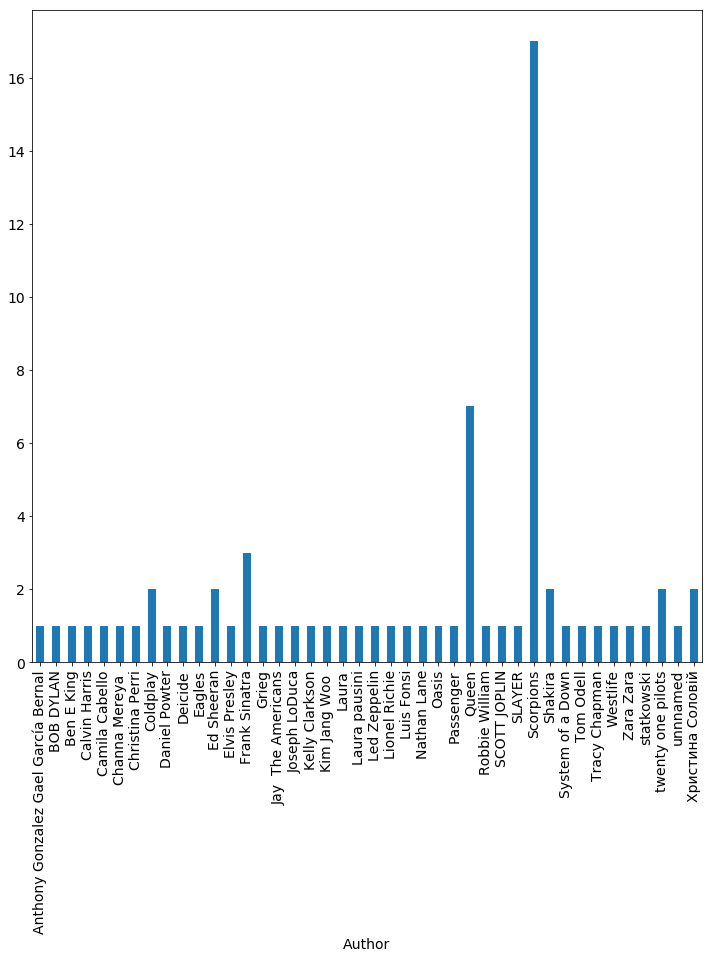

In [68]:
ganreGrouped = df_full.groupby(['Author'])['Author'].count()
ganreGrouped.plot(kind='bar',figsize=(12, 12))
plt.rcParams.update({'font.size': 14})
plt.show()

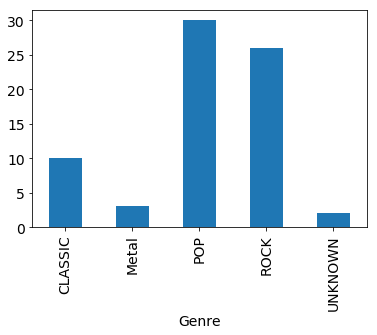

In [69]:
ganreGrouped = df_full.groupby(['Genre'])['Genre'].count()
ganreGrouped.plot(kind='bar');
plt.show()

In [167]:
#Correlation matrix
correlations = df_full.corr().fillna(0)
correlations

,0,1,2,3,4,5,6,7,8,9,...,5205,5206,5207,5208,5209,5210,5211,5212,5213,5214
0,1.000000,0.814685,0.605492,0.422165,0.249182,0.289033,0.276502,0.235219,0.245978,0.233581,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.814685,1.000000,0.789197,0.570691,0.368388,0.380233,0.406699,0.314813,0.281842,0.252694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.605492,0.789197,1.000000,0.679394,0.511097,0.463069,0.458144,0.399739,0.280225,0.285000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.422165,0.570691,0.679394,1.000000,0.623773,0.619895,0.601659,0.484940,0.335167,0.388315,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.249182,0.368388,0.511097,0.623773,1.000000,0.893085,0.846795,0.788260,0.635438,0.643369,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.289033,0.380233,0.463069,0.619895,0.893085,1.000000,0.915614,0.850674,0.688354,0.676804,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.276502,0.406699,0.458144,0.601659,0.846795,0.915614,1.000000,0.889062,0.716057,0.685940,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.235219,0.314813,0.399739,0.484940,0.788260,0.850674,0.889062,1.000000,0.789485,0.717285,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.245978,0.281842,0.280225,0.335167,0.635438,0.688354,0.716057,0.789485,1.000000,0.842740,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.233581,0.252694,0.285000,0.388315,0.643369,0.676804,0.685940,0.717285,0.842740,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


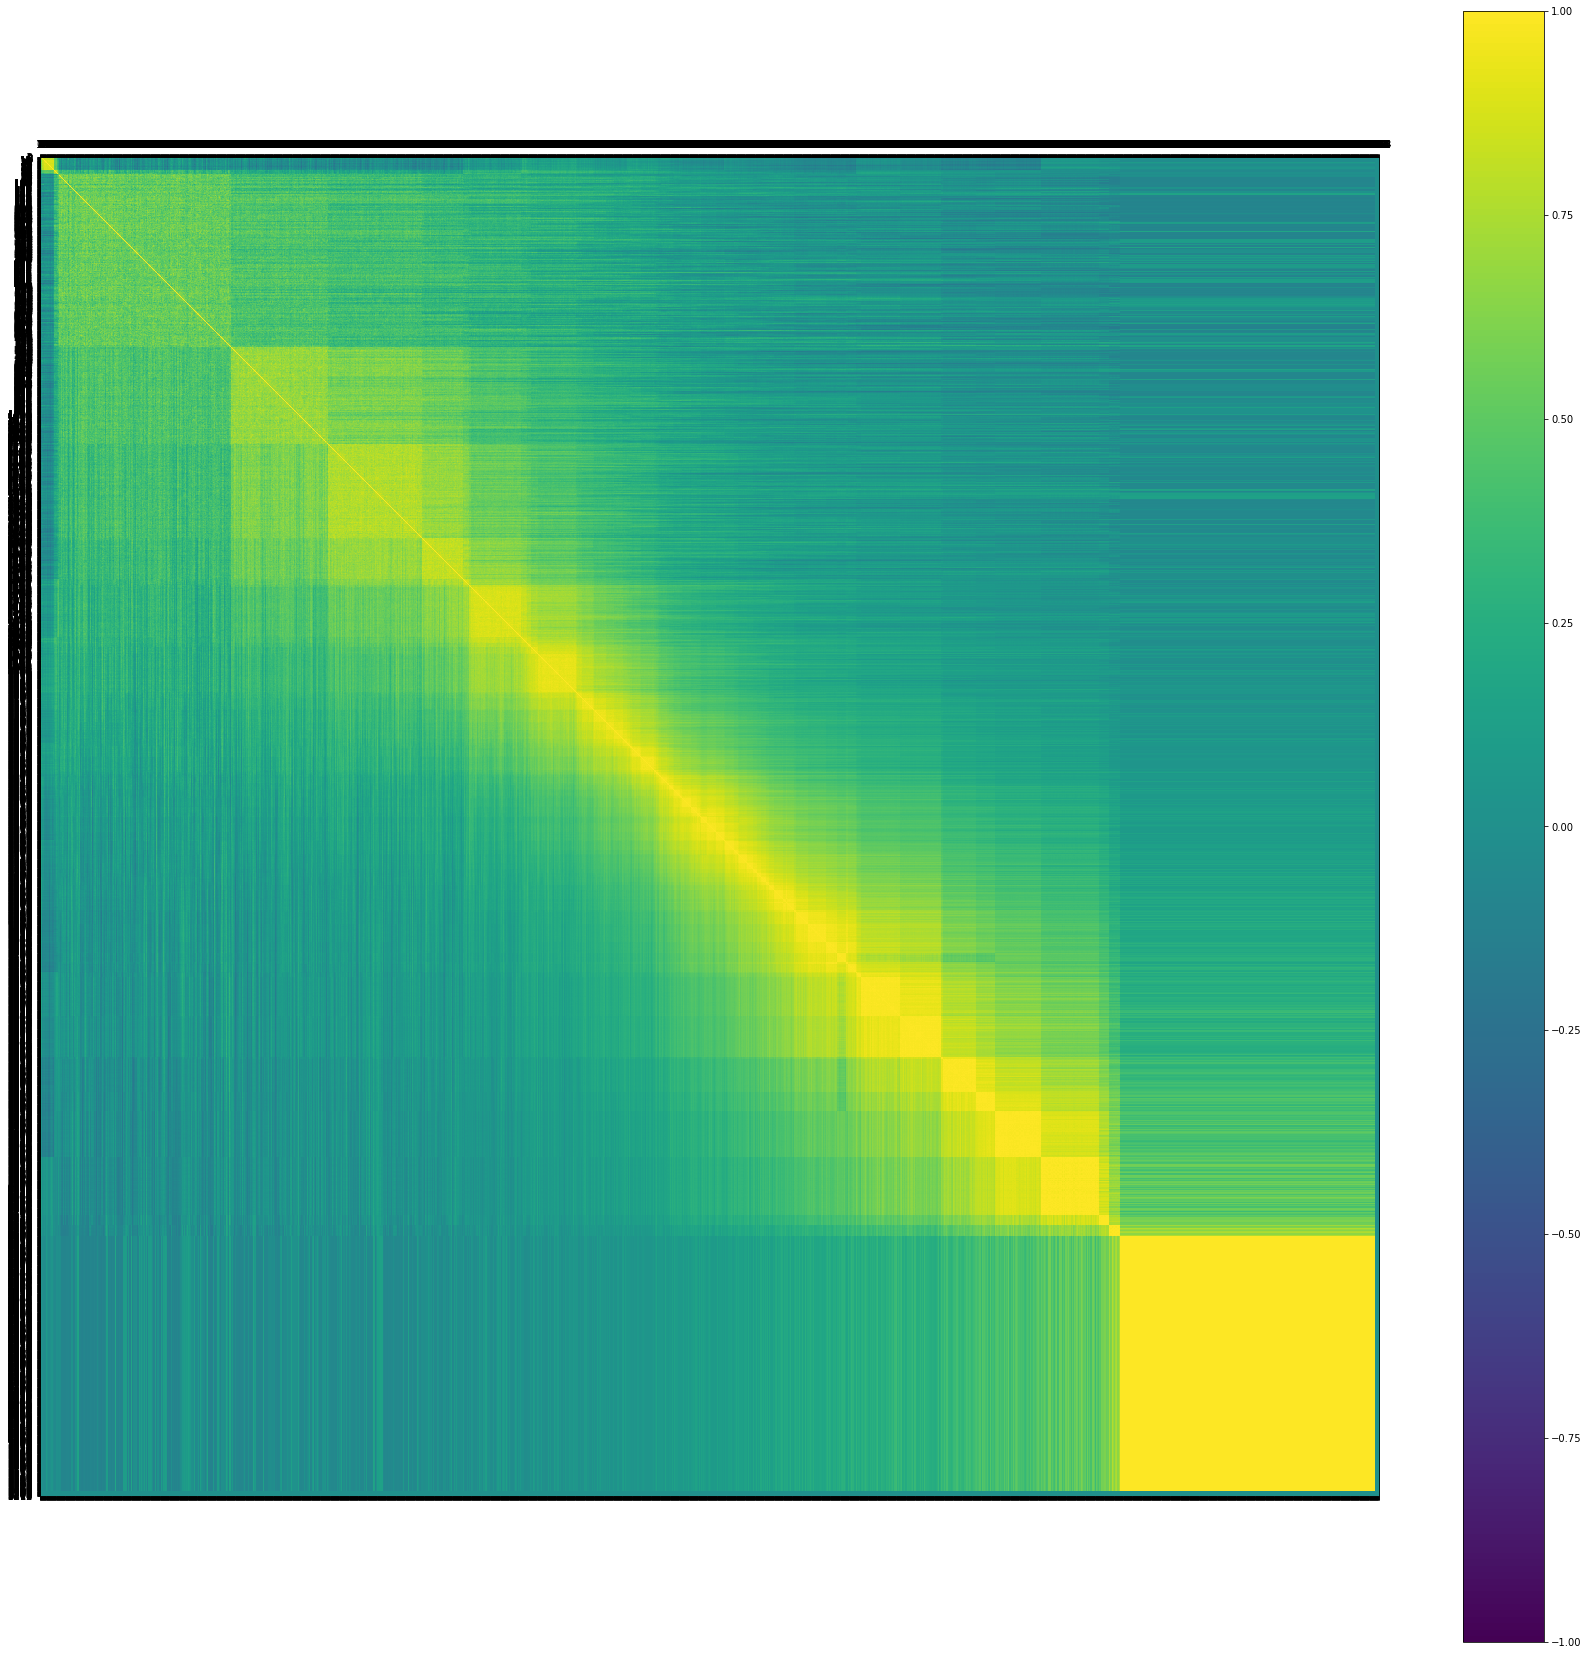

In [127]:
import matplotlib.pyplot as plt
import numpy as np

# plot correlation matrix

names = list(correlations.columns)
fig = plt.figure(figsize=[30,30])
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,5215,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

# Unsupervised learning: clustering

In [172]:
dfhashes=dfhashes.fillna(0)
dataframe_std = pd.DataFrame(StandardScaler().fit_transform(dfhashes))
cov_std = dataframe_std.corr()
cov_std=cov_std.fillna(0)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\numpy\core\numeric.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


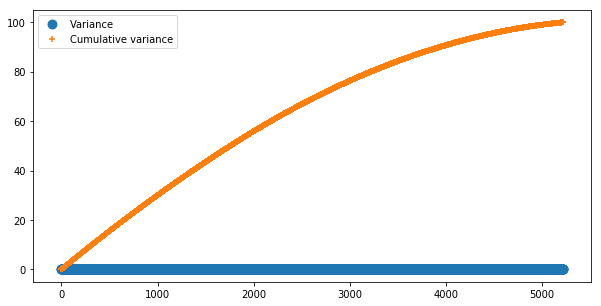

In [174]:
#We need to take components with the highest value to keep the information on the projection space. 
#Here we're sure that we need the first and the second. For the rest we run the computation bellow.

eig_vals, eig_vect = np.linalg.eig(cov_std)
eig_pairs = [(np.abs(eig_vals[i]), eig_vect[:,i]) for i in range(len(eig_vals))]

sum_ev = sum(eig_vals)
pve = [(i / sum_ev)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_pve = np.cumsum(pve)

fig = plt.figure(figsize=[10,5])
plt.scatter([i for i in range(len(dataset_std.columns))], pve, s=80)
plt.scatter([i for i in range(len(dataset_std.columns))], cum_var_pve, marker='+')
plt.legend(['Variance', 'Cumulative variance'])
plt.show()

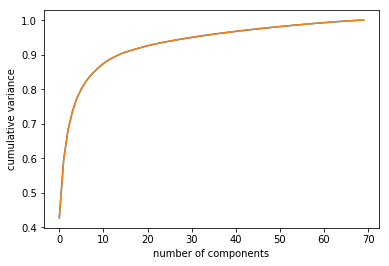

In [176]:
pca = PCA().fit(dfhashes)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative variance');
plt.show()

In [18]:
dataframe_pca = PCA(n_components=2).fit_transform(dataframe_std)

dataframe_pca

#the coordinates of the points projected into the space

array([[ -4.89505350e+01,   7.31403248e+01],
       [ -2.40300887e+01,   7.92593429e+00],
       [  3.19386155e+01,  -2.10378859e+01],
       [ -1.23756063e+01,  -8.52920377e+00],
       [ -1.50742218e+01,  -3.67588035e+00],
       [  4.23055466e+01,  -1.18122994e+01],
       [  7.05189270e+00,  -1.38940425e+01],
       [  1.69114038e+01,  -2.57993964e+01],
       [ -1.03502505e+00,  -1.07756891e+01],
       [ -1.07328595e+01,  -1.05041501e+01],
       [ -2.28636838e+00,  -2.63212729e+01],
       [  8.12439583e+01,   7.15134968e+00],
       [ -2.52756214e+00,  -1.26739222e+01],
       [ -4.94745585e+00,  -1.31003172e+01],
       [ -2.58084446e+01,   1.43935890e+01],
       [  3.49655231e+00,  -1.89707273e+01],
       [ -3.31266470e+01,   2.96480650e+01],
       [ -1.86180495e+01,  -4.13652533e-02],
       [ -3.33280048e+01,   3.07814623e+01],
       [ -2.77487777e+01,   1.80630637e+01],
       [ -5.98955352e+01,   1.06422118e+02],
       [ -2.49082069e+01,   1.05147072e+01],
       [  

<p style="font-size: 1.7rem"> This show how our songs representation with respect to their special hashes, since we have big amout close to each outhers it mean that alot of song have same maximal frequensy

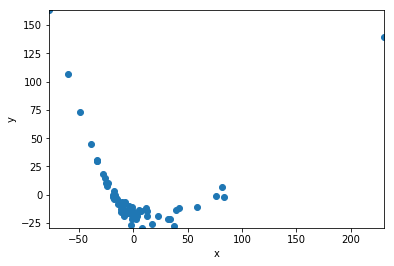

In [19]:
plt.scatter(dataframe_pca[:,0],dataframe_pca[:,1])

plt.xlabel('x')
plt.ylabel('y')
plt.xlim(min(dataframe_pca[:,0]),max(dataframe_pca[:,0]))
plt.ylim(min(dataframe_pca[:,1]),max(dataframe_pca[:,1]))

plt.show()

In [182]:
k = range(2,20)
silhouette = [0.0]*20
for n_clusters in k:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(dataframe_pca)
    silhouette_avg = silhouette_score(dataframe_pca, cluster_labels)
    silhouette[n_clusters] = silhouette_avg
    
# We compute the score for each cluster and take the closest to 1
best_nb_clust = silhouette.index(max(silhouette)) 
print("The best number of cluster is : " + str(best_nb_clust))

The best number of cluster is : 2


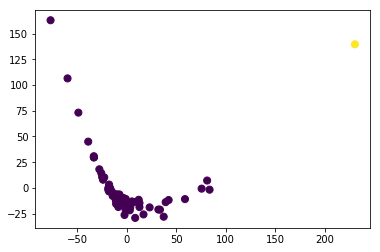

In [179]:
kmeans_label = KMeans(n_clusters=2, random_state=10).fit_predict(dataframe_pca)
plt.scatter(dataframe_pca[:, 0], dataframe_pca[:, 1], c=kmeans_label,s=50,cmap='viridis');
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.834987361982


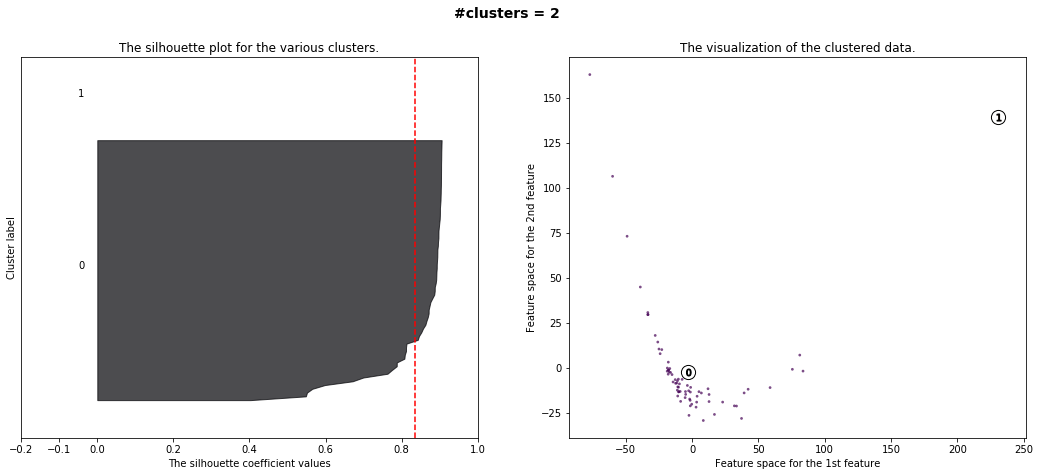

For n_clusters = 3 The average silhouette_score is : 0.702288559342


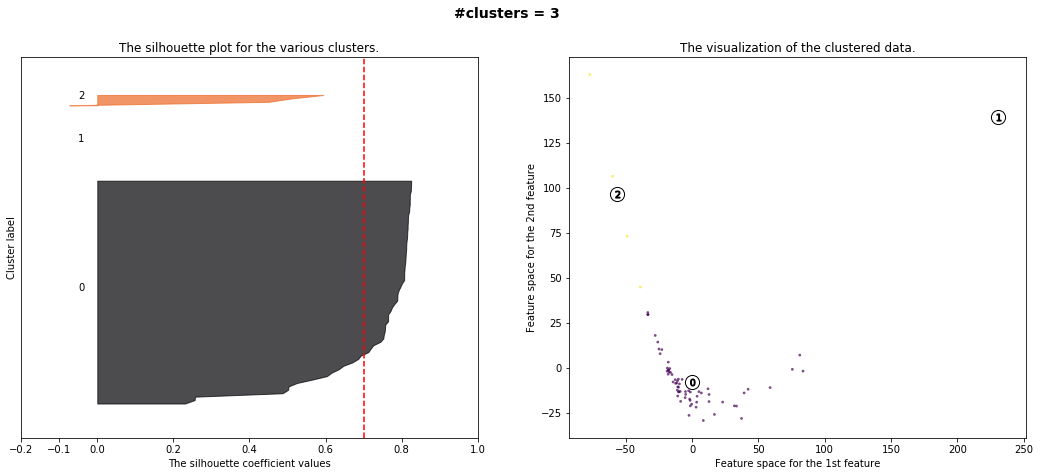

For n_clusters = 4 The average silhouette_score is : 0.604247818379


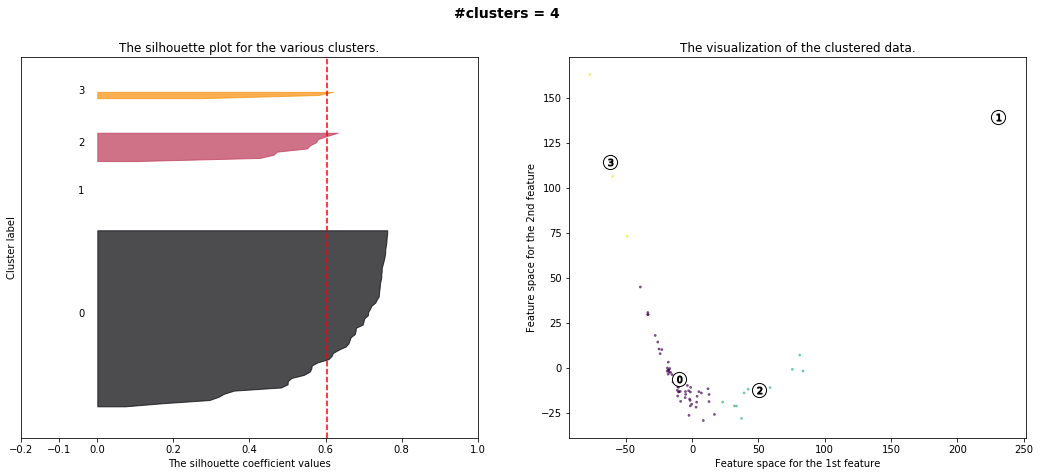

For n_clusters = 5 The average silhouette_score is : 0.57124965693


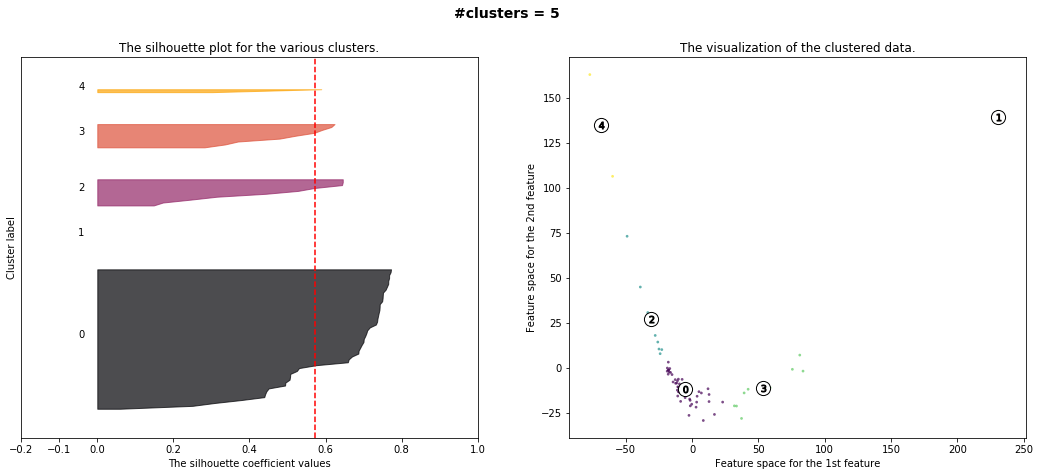

For n_clusters = 6 The average silhouette_score is : 0.527046673433


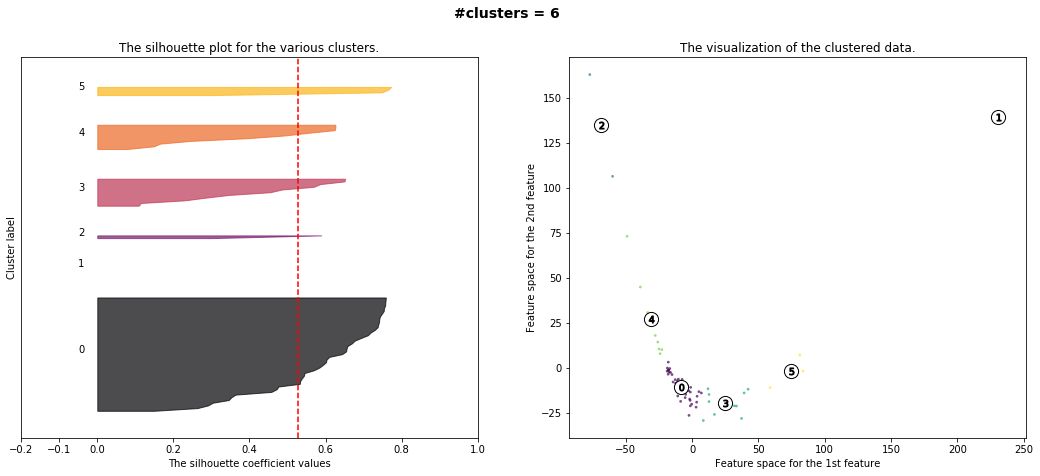

For n_clusters = 7 The average silhouette_score is : 0.521728418291


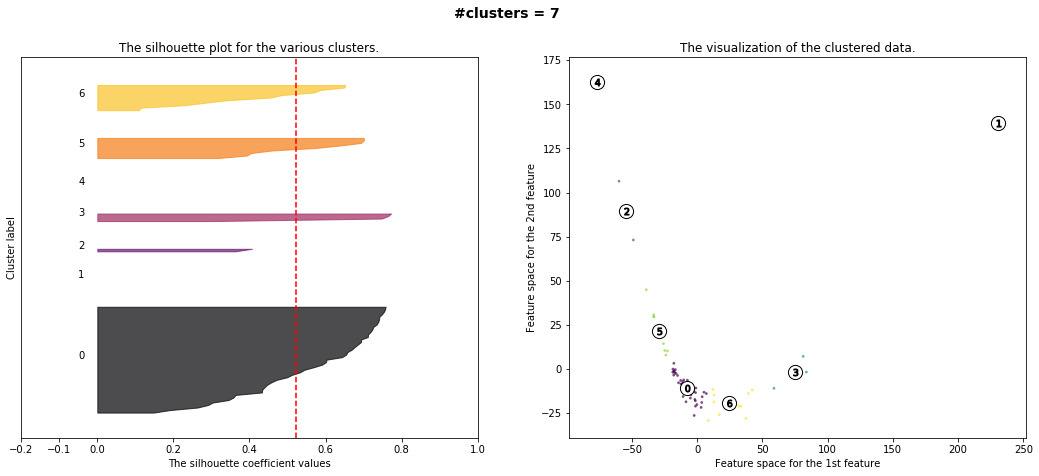

In [51]:
X = dataframe_pca
range_n_clusters = range(2,8)

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)              
    fig.set_size_inches(18, 7)   
    
    # Limit of the figure for the silhouette -1, 1 
    ax1.set_xlim([-0.2, 1])                             
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator with speed = 10
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    # Silhouette score between -1 (worse) and 1 (better) 
    silhouette_avg = silhouette_score(X, cluster_labels)  
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.inferno(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = plt.cm.inferno(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c= cluster_labels , edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("#clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

# Supervised learning:KNN

<p style="font-size: 1.7rem"> Now let's talk about supervised learning, first we will show <b>K-nearest neighbors</b>
<img src="knn.jpg">

<p style="font-size: 1.7rem"> We split our info for two sets,  training and testing, here we will show features of our KNN 

###  - genre of the song recognition

In [8]:
trainingSet=[]
testSet=[]
split =0.9

In [9]:
numbers=[]
for x in range(len(df)-1):
    if random.random() < split:
        trainingSet.append(df.loc[x,:])
    else:
        testSet.append(df.loc[x,:])
        numbers.append(x)

In [10]:
def euclideanDistance(instance1, instance2, length):
	distance = 0
	for x in range(length):
		distance += pow((instance1[x] - instance2[x]), 2)
	return math.sqrt(distance)
 
def getNeighbors(trainingSet, testInstance, k):
	distances = []
	length = len(testInstance)-1
	for x in range(len(trainingSet)):
		dist = euclideanDistance(testInstance, trainingSet[x], length)
		distances.append((trainingSet[x], dist))
	distances.sort(key=operator.itemgetter(1))
	neighbors = []
	for x in range(k):
		neighbors.append(distances[x][0])
	return neighbors
 

In [11]:
def getResponse(neighbors):
	classVotes = {}
	for x in range(len(neighbors)):
		response = neighbors[x][-1]
		if response in classVotes:
			classVotes[response] += 1
		else:
			classVotes[response] = 1
	sortedVotes = sorted(classVotes.items(), key=operator.itemgetter(1), reverse=True)
	return sortedVotes[0][0]


In [12]:
print ('Train set: ' + repr(len(trainingSet)))
print ('Test set: ' + repr(len(testSet)))

Train set: 63
Test set: 6


In [13]:
predictions=[]
k = 5
for x in range(len(testSet)):
	neighbors = getNeighbors(trainingSet, testSet[x], k)
	result = getResponse(neighbors)
	predictions.append(result)
	print('> predicted=' + repr(result) + ', actual=' + repr(testSet[x][-1])+' song: '+dfname.iat[numbers[x],0]+' author: '+dfauthor.iat[numbers[x],0])


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in longlong_scalars
  after removing the cwd from sys.path.


> predicted='POP ', actual='CLASSIC' song: In the Hall of the Mountain King  author: Grieg
> predicted='POP ', actual='POP ' song: Silent Night   author: Kelly Clarkson
> predicted='POP ', actual='ROCK' song: Sweet Lady   author: Queen
> predicted='POP ', actual='ROCK' song: He's a Woman, She's a Man  author: Scorpions
> predicted='POP ', actual='ROCK' song: Love Is Blind  author: Scorpions
> predicted='POP ', actual='CLASSIC' song: idk  author: statkowski


### - finding closest songs

In [74]:
df = pd.concat([dfhashes, dfstyle], axis=1, join='inner')
df_hashes_names = pd.concat([dfhashes_set, dfname_set] , axis=1)

In [75]:
df_hashes_names=df_hashes_names.fillna(0)

In [76]:
trainingSet=[]
testSet=[df_hashes_names.loc[10,:],df_hashes_names.loc[6,:]]
for x in range(len(df_hashes_names)-1):
    trainingSet.append(df_hashes_names.loc[x,:])

In [82]:
predictions=[]
k = 5
for x in range(len(testSet)):
    neighbors = getNeighbors(trainingSet, testSet[x], k)
    print('> search for ' + repr(testSet[x][-1]))
    for i in range(len(neighbors)):
        print('closest=' + str(neighbors[i][-1]))


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in longlong_scalars
  after removing the cwd from sys.path.


> search for 'Homage for Satan '
closest=Homage for Satan 
closest=Passion Rules the Game 
closest=Sweet Lady  
closest=No one like you 
closest=I Wanna Grow Old With You 
> search for 'A Thousand Years '
closest=A Thousand Years 
closest=Wonderwall 
closest=I'm Goin' Mad 
closest=Despacito 
closest=Always Somewhere 


###  - neural network for prediction genre

In [84]:
dfname = pd.read_csv('data_tittles.csv', sep=',', header=None)
dfname.columns = ["Title"]
dfgenre = pd.read_csv('data_styles.csv', sep=',', header=None)
dfgenre.columns = ['Genre']
dfgenre['Genre'] = dfgenre['Genre'].str.strip()
dfauthor = pd.read_csv('data_authors.csv', sep=',', header=None)
dfauthor.columns = ["Author"]
dfhashes = pd.read_csv('data.csv', sep=',', header=None)
df_full = pd.concat([dfhashes,dfauthor,dfname,dfgenre] , axis=1)
df_full=df_full.fillna(0)
dfhashes=dfhashes.fillna(0)

In [85]:
import glob
import os
import numpy as np
import keras
from keras.layers import Input, Activation, Dense, BatchNormalization,Dropout
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint,Callback
import keras.backend as K
from keras.optimizers import SGD

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [86]:
model = Sequential()
model.add(Dense(units=5215*2, activation='sigmoid', input_dim=5215))
model.add(Dense(units=1000, activation='sigmoid'))

#model.add(Dropout(0.1))
model.add(Dense(units=5, activation='softmax'))

sgd = SGD(lr=0.01, momentum=0.9, decay=0, nesterov=True)
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10430)             54402880  
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              10431000  
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5005      
Total params: 64,838,885
Trainable params: 64,838,885
Non-trainable params: 0
_________________________________________________________________


In [87]:
def genreToVector(genre):
    genres = ['POP', 'CLASSIC', 'UNKNOWN', 'ROCK', 'Metal']
    vector = [0] * len(genres)
    vector[genres.index(genre)] = 1
    return vector

In [88]:
def vectorToGenre(vector):
    genres = ['POP', 'CLASSIC', 'UNKNOWN', 'ROCK', 'Metal']
    genre = genres[np.where(vector==1)[0][0]]
    return genre

In [89]:
genre_train_str = np.array(df_full['Genre'])
genre_train = np.array(list(map(genreToVector, genre_train_str)))

data_train_nonorm = np.array(dfhashes)
data_train = [0]*len(data_train_nonorm)

for i in range(len(data_train_nonorm)):
    data_train[i] = data_train_nonorm[i]/float(max(data_train_nonorm[i]))
     
data_train = np.array(data_train)

In [90]:
#earlystop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-5, patience=5, verbose=1, mode='auto')
model.fit(data_train, genre_train, epochs=200, batch_size=5)

Epoch 1/200
71/71 [==============================] - 17s 232ms/step - loss: 2.8564 - acc: 0.3099
Epoch 2/200
71/71 [==============================] - 14s 197ms/step - loss: 1.7149 - acc: 0.4648
Epoch 3/200
71/71 [==============================] - 14s 197ms/step - loss: 1.2901 - acc: 0.4366
Epoch 4/200
71/71 [==============================] - 14s 191ms/step - loss: 1.3377 - acc: 0.4507
Epoch 5/200
71/71 [==============================] - 14s 192ms/step - loss: 1.2845 - acc: 0.4507
Epoch 6/200
71/71 [==============================] - 14s 194ms/step - loss: 1.2614 - acc: 0.3944
Epoch 7/200
71/71 [==============================] - 14s 196ms/step - loss: 1.2709 - acc: 0.3803
Epoch 8/200
71/71 [==============================] - 14s 197ms/step - loss: 1.1919 - acc: 0.5493
Epoch 9/200
71/71 [==============================] - 14s 198ms/step - loss: 1.2928 - acc: 0.3803
Epoch 10/200
71/71 [==============================] - 14s 196ms/step - loss: 1.2262 - acc: 0.5070
Epoch 11/200
71/71 [=========

71/71 [==============================] - 19s 272ms/step - loss: 0.0132 - acc: 1.0000
Epoch 168/200
71/71 [==============================] - 19s 268ms/step - loss: 0.0138 - acc: 1.0000
Epoch 169/200
71/71 [==============================] - 19s 271ms/step - loss: 0.0121 - acc: 1.0000
Epoch 170/200
71/71 [==============================] - 19s 271ms/step - loss: 0.0132 - acc: 1.0000
Epoch 171/200
71/71 [==============================] - 19s 268ms/step - loss: 0.0129 - acc: 1.0000
Epoch 172/200
71/71 [==============================] - 19s 274ms/step - loss: 0.0121 - acc: 1.0000
Epoch 173/200
71/71 [==============================] - 19s 270ms/step - loss: 0.0106 - acc: 1.0000
Epoch 174/200
71/71 [==============================] - 19s 272ms/step - loss: 0.0102 - acc: 1.0000
Epoch 175/200
71/71 [==============================] - 19s 269ms/step - loss: 0.0103 - acc: 1.0000
Epoch 176/200
71/71 [==============================] - 20s 287ms/step - loss: 0.0095 - acc: 1.0000
Epoch 177/200
71/71 [===

In [93]:
end_result = model.evaluate(x_train, y_train, batch_size=1)
print(loss_and_metrics)

71/71 [==============================] - 3s 40ms/step
[0.004926996493120553, 1.0]


In [96]:
count_t = 0
count_f = 0

for line in range(0,71):
    print(dfgenre.iloc[[line]].values[0][0])
    classes = model.predict(np.array(dfhashes.iloc[[line]]))
    vector = np.zeros(5)
    vector[np.where(classes == max(max(classes)))[1][0]] = 1
    print(vectorToGenre(vector))
    
    if vectorToGenre(vector) == dfgenre.iloc[[line]].values[0][0]:
        print('True')
        count_t += 1  
    else :
        print('False')
        count_f += 1
    print()

POP
POP
True

POP
POP
True

CLASSIC
CLASSIC
True

POP
POP
True

POP
POP
True

UNKNOWN
ROCK
False

POP
POP
True

POP
POP
True

ROCK
ROCK
True

POP
POP
True

Metal
Metal
True

CLASSIC
CLASSIC
True

POP
POP
True

POP
POP
True

POP
POP
True

CLASSIC
CLASSIC
True

CLASSIC
CLASSIC
True

CLASSIC
CLASSIC
True

CLASSIC
CLASSIC
True

POP
POP
True

CLASSIC
CLASSIC
True

POP
POP
True

CLASSIC
CLASSIC
True

POP
POP
True

POP
POP
True

ROCK
ROCK
True

POP
POP
True

POP
POP
True

POP
POP
True

POP
POP
True

POP
POP
True

ROCK
ROCK
True

ROCK
ROCK
True

ROCK
ROCK
True

ROCK
ROCK
True

ROCK
ROCK
True

ROCK
ROCK
True

ROCK
ROCK
True

POP
POP
True

ROCK
ROCK
True

ROCK
ROCK
True

ROCK
ROCK
True

ROCK
ROCK
True

ROCK
ROCK
True

ROCK
ROCK
True

ROCK
ROCK
True

ROCK
ROCK
True

ROCK
ROCK
True

ROCK
ROCK
True

ROCK
ROCK
True

ROCK
ROCK
True

ROCK
ROCK
True

ROCK
ROCK
True

ROCK
ROCK
True

ROCK
ROCK
True

ROCK
ROCK
True

CLASSIC
CLASSIC
True

POP
POP
True

POP
POP
True

Metal
Metal
True

CLASSIC
CLASSIC
True



In [95]:
print('# of true : ' + str(count_t))
print('# of false : ' + str(count_f)) 

# of true : 69
# of false : 2


###  - Shazam alogithm

In [13]:
i_love_this_song = df_full.iloc[6][1000:2000]
print('We are trying to predict result for this song' + str(df_full.iloc[6]['Author'])
      + ' - '+ str(df_full.iloc[6]['Title']) 
      + 'and genre of song is '+  str(df_full.iloc[6]['Genre']))

We are trying to predict result for this songChristina Perri - A Thousand Years and genre of song is POP


In [10]:
def subfinder(mylist, pattern):
    result = []
    ansv = False
    for i in range(0,len(mylist)):   
        print('Checking the {0} song for similar interval'.format(i))
        for j in range(len(mylist.iloc[i]) - len(pattern)):            
            if list(pattern) == list(mylist.iloc[i][j:j + len(pattern)]):
                 ansv = True
        if ansv == True:
            result.append(mylist.iloc[i])
            ansv = False
            break
    return result

In [11]:
ans = subfinder(df_full, df_full.iloc[6][1000:2000])


Checking the 0 song for similar interval
Checking the 1 song for similar interval
Checking the 2 song for similar interval
Checking the 3 song for similar interval
Checking the 4 song for similar interval
Checking the 5 song for similar interval
Checking the 6 song for similar interval


In [12]:
ans = pd.DataFrame(ans)
print(str(ans['Author'].values[0]) +' - '+ str(ans['Title'].values[0]) +'and genre of song is '+  str(ans['Genre'].values[0]))

Christina Perri - A Thousand Years and genre of song is POP


### Conclusion
<p style="font-size: 1.7rem"> So in our project we were working with song recognition, for that we create our new dataset, by algorithm parse it into specific unique representation, then we did some data analisys which are visualized on graphics in report, unsupervised learning is presented by k-means clasteing, and for supervised learning we used few algorithms as <b>KNN</b> and <b>neural network</b>, also we used the shazam algorithm for detecting song, as result we got genre recognition with accuracy 100% for neural network, and 77% for KNN, also by KNN we found the most similar songs for chosen one, and shazam alogrithm gave us result of song recognition with small interval of song as input.